## Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибку модели из п.2 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

In [49]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])



In [9]:
data

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02,20:00:00,44057.0,2018,8,2,3,214,31,3,20,0,0,0
2018-08-02,21:00:00,43256.0,2018,8,2,3,214,31,3,21,0,0,0
2018-08-02,22:00:00,41552.0,2018,8,2,3,214,31,3,22,0,0,0


In [12]:
brent_data

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0


In [7]:
brent_data.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,2667.000000,2667.000000,2667.00000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,81.533547,2014.661042,6.51706,15.715786,2.505062,182.901762,26.486689,2.537308,0.027747,0.026997,0.029621
std,26.349469,2.663525,3.43026,8.780275,1.112684,104.741067,14.935147,1.894937,0.164277,0.162104,0.169572
min,27.850000,2010.000000,1.00000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,56.840000,2012.000000,4.00000,8.000000,2.000000,92.000000,14.000000,1.000000,0.000000,0.000000,0.000000
50%,77.710000,2015.000000,7.00000,16.000000,3.000000,183.000000,27.000000,2.000000,0.000000,0.000000,0.000000
75%,108.190000,2017.000000,9.00000,23.000000,3.000000,273.000000,39.000000,4.000000,0.000000,0.000000,0.000000
max,126.900000,2019.000000,12.00000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


/Users/daniilstv/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


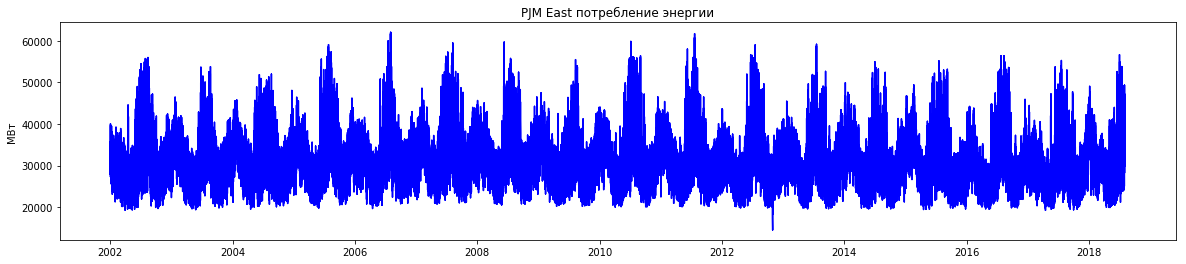

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Text(0.5,0,'t')

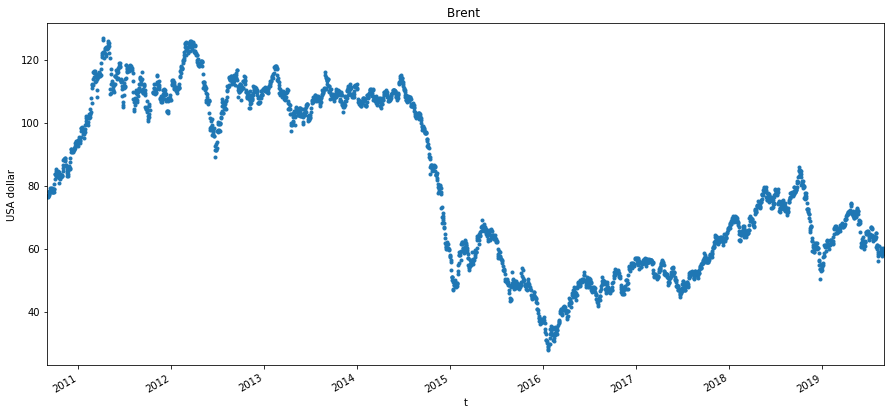

In [8]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

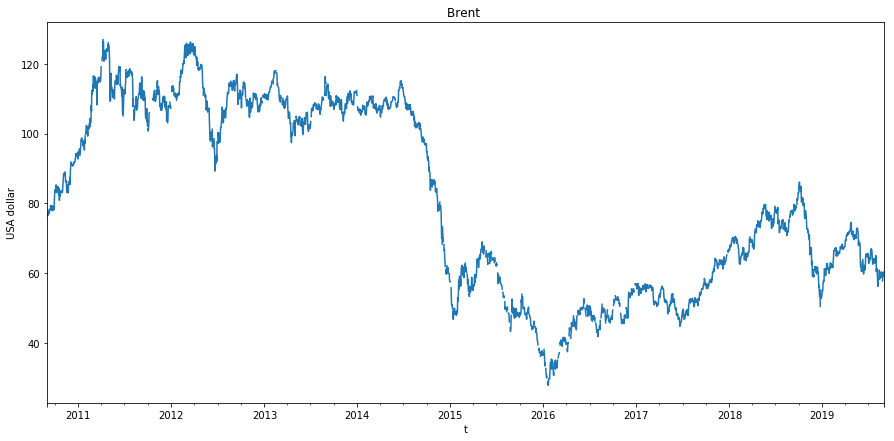

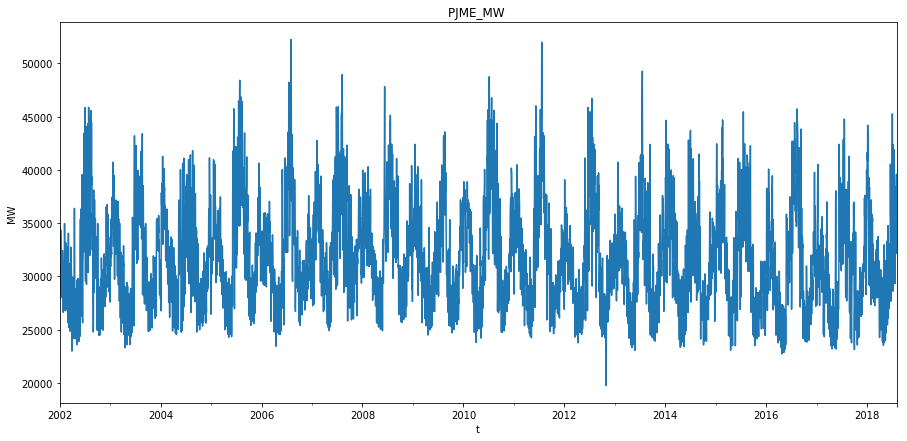

In [16]:
data_d = data.resample('D').mean()
brent_data_d = brent_data.resample('D').mean()

_ = brent_data_d['Значение'].plot( style='-', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.show()

_ = data_d['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

In [34]:
b_ar = brent_data['Значение'].values
b_s = pd.DataFrame(data = brent_data[['Значение']])

In [35]:
b_s.head()

,Значение
Дата,
2010-09-01,76.37
2010-09-02,76.89
2010-09-03,76.57
2010-09-04,76.62
2010-09-05,76.63


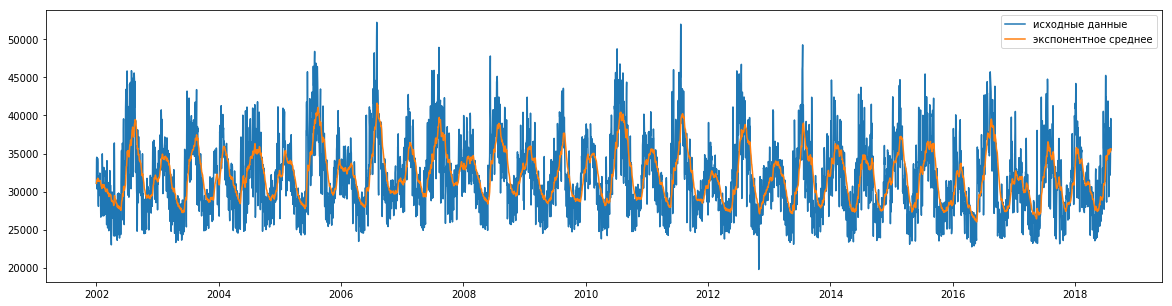

In [43]:
exp_av = exponential_smoothing(data_d['PJME_MW'], 0.05)
df = pd.DataFrame(exp_av, columns=['exp_av'], index=data_d.index)


plt.figure(figsize=(20,5))
plt.plot(data_d.index, data_d['PJME_MW'], label='исходные данные')
plt.plot(df.index, df['exp_av'], label='экспонентное среднее')
plt.legend(loc='upper right')

In [45]:
p = 3

for i in range(1, p+1):
    df[f't{i}'] = 0
    df.iloc[1:, -1] = df.iloc[:-1, -2].values

df

,exp_av,t1,t2,t3
Date,,,,
2002-01-01,31080.739130,0,0,0
2002-01-02,31239.779257,0,0,0
2002-01-03,31403.384044,0,0,0
2002-01-04,31518.987759,0,0,0
2002-01-05,31463.294621,0,0,0
...,...,...,...,...
2018-07-30,35241.910443,0,0,0
2018-07-31,35206.769087,0,0,0
2018-08-01,35407.970216,0,0,0


In [51]:
train, test = split_data_b(df, '2017-01-01')
scaller = StandardScaler()

Text(0.5,1,'Brent 2010-2019')

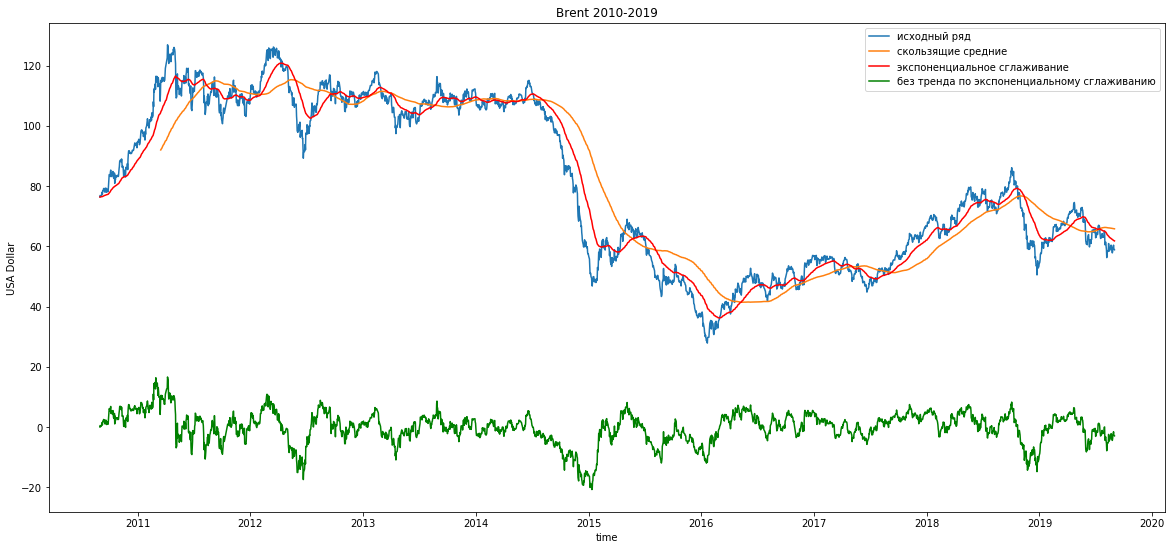

In [36]:
N2 = 24*7


b_ar_exp_1 = exponential_smoothing(brent_data['Значение'], 0.03)


b_s['z_data'] = (b_s['Значение'] - b_s['Значение'].rolling(window=N2).mean()) / b_s['Значение'].rolling(window=N2).std()
b_s['zp_data'] = b_s['z_data'] - b_s['z_data'].shift(N2)

plt.figure(figsize=(20, 9))
plt.plot(b_s.index, b_s['Значение'], label='исходный ряд')
plt.plot(b_s['Значение'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(b_s.index,b_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(b_s.index,b_s['Значение'] - b_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('USA Dollar')
plt.legend()
plt.title('Brent 2010-2019') 

In [37]:
df= pd.DataFrame(b_ar_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]


df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
0,76.370000,0.000000,0.000000,0.0000,76.370000,76.370000,76.370000,0.0
1,76.385600,76.370000,0.000000,0.0000,76.370156,76.370468,76.371248,0.0
2,76.391132,76.385600,76.370000,0.0000,76.370366,76.371088,76.372839,0.0
3,76.397998,76.391132,76.385600,76.3700,76.370642,76.371895,76.374851,0.0
4,76.404958,76.397998,76.391132,76.3856,76.370985,76.372887,76.377260,0.0


In [50]:
train, test = split_data_b(df_exp, '2017-01-01')
